In [64]:
import ReplayBuffer

In [65]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import pandas as pd
%matplotlib inline

In [66]:
err_treshold = 10

In [67]:
cmap=plt.cm.jet
z_cmap = plt.cm.gnuplot2

colors = [(.98, .22, 0.01),(.98, .48, 0.01), (.98, 0.84, .01), (.84, 0.98, .01), (.53, 0.98, .01), (.01, .98, .67)]
n_map = LinearSegmentedColormap.from_list('nmap', colors, N=6)

In [68]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=err_treshold)
z_norm = matplotlib.colors.Normalize(vmin=0.25, vmax=0.6)
n_norm = matplotlib.colors.Normalize(vmin=1, vmax=6)

In [69]:
taget_points = np.loadtxt('../src/test_points.txt')
optim = pd.read_csv('../runs_256/test_optim.csv',header=0)
optim['target_points'] = optim['test_nr'].apply(lambda x: taget_points[x])
optim['target_points'] = optim['test_nr'].apply(lambda x: taget_points[x])
optim['error_log'] = optim['error_log'].apply(lambda x: 1 if x == float('inf') else x)

In [70]:
tests = [12000,25000,50000,75000,100000,'optim']
# tests = [25000,50000,100000]
tests_error = []

/tmp/ipykernel_991655/3306215486.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


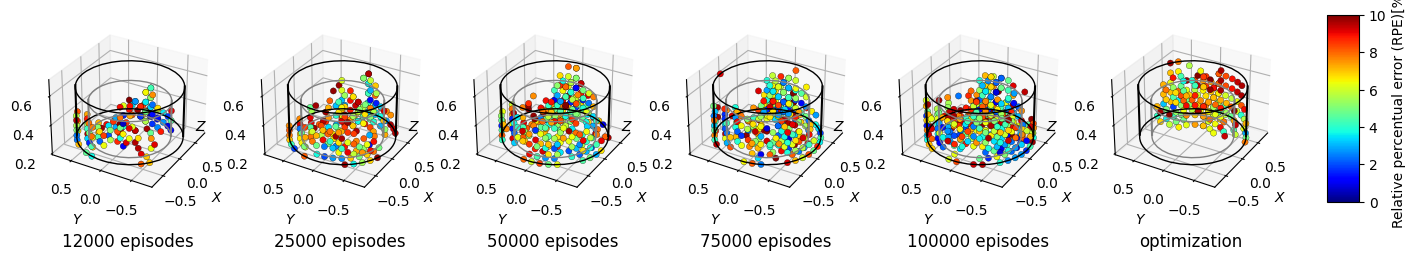

In [71]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs_256/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values.copy()

    perc_error*=100
    tests_error.append(perc_error)
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)


    ax = fig.add_subplot(1, len(tests), i+1, projection='3d')

    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.79, .79)
    ax.set_ylim(-.79, .79)
    ax.set_zlim(0.2, .7)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(azim=-150,elev=30)
    feasible_plot = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=1, edgecolors="black", linewidths=0.2,
                                    cmap=cmap, norm=norm)

    # train 
    r = 0.6
    top = Circle( (0, 0),r, fill = False, color='grey')
    down = Circle( (0, 0),r, fill = False, color='grey')
    ax.add_patch(top)
    ax.add_patch(down)
    art3d.pathpatch_2d_to_3d(top, z=0.25, zdir="z")
    art3d.pathpatch_2d_to_3d(down, z=0.5, zdir="z")

    x0 = r * np.cos(-np.pi/2+0.5)
    y0 = r * np.sin(-np.pi/2+0.5)

    x1 = r * np.cos(np.pi/2+0.5)
    y1 = r * np.sin(np.pi/2+0.5)

    plt.plot([x0,x0],[y0,y0],[0.25,0.5], color='gray',zorder=2.5)
    plt.plot([x1,x1],[y1,y1],[0.25,0.5], color='gray',zorder=2.5)
    
    # test 
    r = 0.78
    top = Circle( (0, 0),r, fill = False, color='black')
    down = Circle( (0, 0),r, fill = False, color='black')
    ax.add_patch(top)
    ax.add_patch(down)
    art3d.pathpatch_2d_to_3d(top, z=0.25, zdir="z")
    art3d.pathpatch_2d_to_3d(down, z=0.6, zdir="z")

    x0 = r * np.cos(-np.pi/2+0.5)
    y0 = r * np.sin(-np.pi/2+0.5)

    x1 = r * np.cos(np.pi/2+0.5)
    y1 = r * np.sin(np.pi/2+0.5)

    plt.plot([x0,x0],[y0,y0],[0.25,0.6], color='black',zorder=2.5)
    plt.plot([x1,x1],[y1,y1],[0.25,0.6], color='black',zorder=2.5)
       
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-35)
    else:
        ax.set_title( 'optimization', y=.0, pad=-35)
    
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(feasible_plot, shrink=0.3, label='Relative percentual error (RPE)[%]', cax=cbar_ax)
# fig.suptitle('Target positions with RPE $\leq$ 0.1')
fig.savefig(os.path.join('plots', f'feasible_filtered.pdf'), dpi=500, bbox_inches='tight')
fig.show()

/tmp/ipykernel_991655/392052307.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


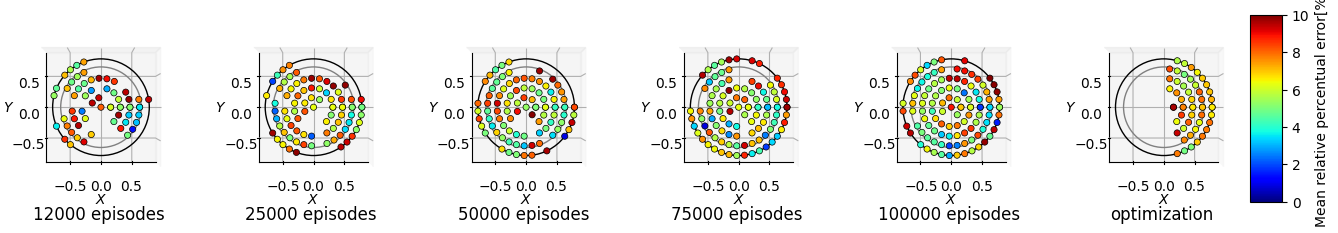

In [72]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs_256/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values.copy()

    perc_error*=100
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)    


    # generate surface
    xy_pair = []
    err = []

    for j,p in enumerate(feasible_region):
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            err.append([err_filter[j]])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            err[idx].append(err_filter[j])

    mean_err = [np.mean(e) for e in err]
    surface = np.append(np.array(xy_pair),np.array(mean_err).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d',computed_zorder=False)
    train_area = Circle( (0, 0),0.65, fill = False, color='gray')
    test_area = Circle( (0, 0),0.78, fill = False, color='black')
    ax.add_patch(train_area)
    ax.add_patch(test_area)
    art3d.pathpatch_2d_to_3d(train_area, z=0, zdir="z")
    art3d.pathpatch_2d_to_3d(test_area, z=0, zdir="z")
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.85, .85)
    ax.set_ylim(-.85, .85)
    # ax.set_zlim(0, 0.1)
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=-90,elev=90)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-15)
    else:
        ax.set_title( 'optimization', y=.0, pad=-15)

    # surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, cmap=cmap, norm=norm)
    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], 0, alpha=1, edgecolors="black", linewidths=0.5, c=surface[:, 2], cmap=cmap, norm=norm)

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3, label='Mean relative percentual error[%]', cax=cbar_ax)

# fig.suptitle('Mean RPE fo test target positions [RPE $\leq$ 0.1]')
fig.savefig(os.path.join('plots', f'avg_mean_surface_plot.pdf'), dpi=500, bbox_inches='tight')
fig.show()

In [73]:
# fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# # fig = plt.figure(figsize=(10,10))

# for i,test in enumerate(tests):
#     if test != 'optim':
#         rb = joblib.load(
#                 f'../runs_256/test/model_{test}/ReplayBuffer_test.joblib')

#         n_episode = rb.mem_size
#         com0_points = rb.state[:n_episode][:, :3]
#         target_points = rb.state[:n_episode][:, 3:]
#         reached_points = rb.next_state[:n_episode][:, :3]
#         target_error = np.linalg.norm(target_points - reached_points, axis=1)
#         target_distance = np.linalg.norm(target_points-com0_points, axis=1)
#         perc_error = target_error/target_distance
    
#     else:
#         target_points = np.array([target for target in optim['target_points'].values])
#         perc_error = optim['error_log'].values.copy()

#     perc_error*=100
#     # Filter points with perc_error < err_treshold
#     idx = perc_error <= err_treshold
#     err_filter = perc_error[idx]
#     feasible_region = target_points[idx, :]
#     n_of_point = len(err_filter)    


#     # generate surface
#     xy_pair = []
#     err = []

#     for j,p in enumerate(feasible_region):
#         # new point
#         if [p[0],p[1]] not in xy_pair:
#             xy_pair.append([p[0],p[1]])
#             err.append([err_filter[j]])
#         else:
#             # x,y present, get if z > z in array
#             idx = xy_pair.index([p[0],p[1]])
#             err[idx].append(err_filter[j])

#     mean_err = [np.min(e) for e in err]
#     surface = np.append(np.array(xy_pair),np.array(mean_err).reshape(-1,1),axis=1)

#     ax = fig.add_subplot(1, len(tests), i+1, projection='3d',computed_zorder=False)
#     train_area = Circle( (0, 0),0.65, fill = False, color='gray')
#     test_area = Circle( (0, 0),0.78, fill = False, color='black')
#     ax.add_patch(train_area)
#     ax.add_patch(test_area)
#     art3d.pathpatch_2d_to_3d(train_area, z=0, zdir="z")
#     art3d.pathpatch_2d_to_3d(test_area, z=0, zdir="z")
#     ax.margins(x=0,y=0,z=0)
#     ax.set_xlim(-.85, .85)
#     ax.set_ylim(-.85, .85)
#     # ax.set_zlim(0, 0.7)
#     ax.zaxis.line.set_lw(0.)
#     ax.set_zticks([])
#     ax.view_init(azim=-90,elev=90)
#     ax.set_xlabel('$X$')
#     ax.set_ylabel('$Y$')
#     if test != 'optim':
#         ax.set_title( f'{test} episodes', y=.0, pad=-15)
#     else:
#         ax.set_title( 'optimization', y=.0, pad=-15)

#     # surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, cmap=cmap, norm=norm)
#     surf_plot = ax.scatter(surface[:, 0], surface[:, 1], 0, alpha=1, edgecolors="black", linewidths=0.5, c=surface[:, 2], cmap=cmap, norm=norm)

# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# fig.colorbar(surf_plot, shrink=0.3, label='Mean relative percentual error [%]', cax=cbar_ax)

# # fig.suptitle('Mean RPE fo test target positions [RPE $\leq$ 0.1]')
# fig.savefig(os.path.join('plots', f'avg_mean_surface_plot.png'), dpi=500, bbox_inches='tight')
# fig.show()

/tmp/ipykernel_991655/2741872740.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


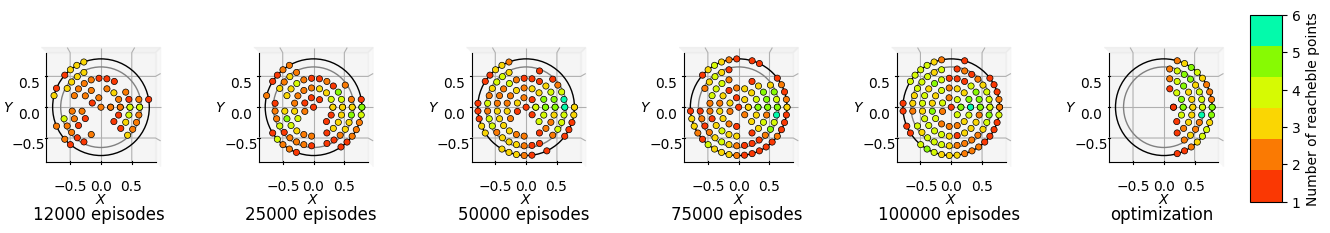

In [74]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs_256/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values.copy()

    perc_error*=100
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)    


    # generate surface
    xy_pair = []
    err = []

    for j,p in enumerate(feasible_region):
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            err.append([err_filter[j]])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            err[idx].append(err_filter[j])

    nr_points = [len(e) for e in err]
    surface = np.append(np.array(xy_pair),np.array(nr_points).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d',computed_zorder=False)
    train_area = Circle( (0, 0),0.65, fill = False, color='gray')
    test_area = Circle( (0, 0),0.78, fill = False, color='black')
    ax.add_patch(test_area)
    ax.add_patch(train_area)
    art3d.pathpatch_2d_to_3d(train_area, z=0, zdir="z")
    art3d.pathpatch_2d_to_3d(test_area, z=0, zdir="z")
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.85, .85)
    ax.set_ylim(-.85, .85)
    # ax.set_zlim(0, 0.7)
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=-90,elev=90)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-15)
    else:
        ax.set_title( 'optimization', y=.0, pad=-15)

    # surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, cmap=cmap, norm=norm)
    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], 0, alpha=1, edgecolors="black", linewidths=0.5, c=surface[:, 2], cmap=n_map, norm=n_norm)

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3, label='Number of reacheble points', cax=cbar_ax)

# fig.suptitle('Mean RPE fo test target positions [RPE $\leq$ 0.1]')
fig.savefig(os.path.join('plots', f'numb_points_surface_plot.pdf'), dpi=500, bbox_inches='tight')
fig.show()

/tmp/ipykernel_991655/105009543.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


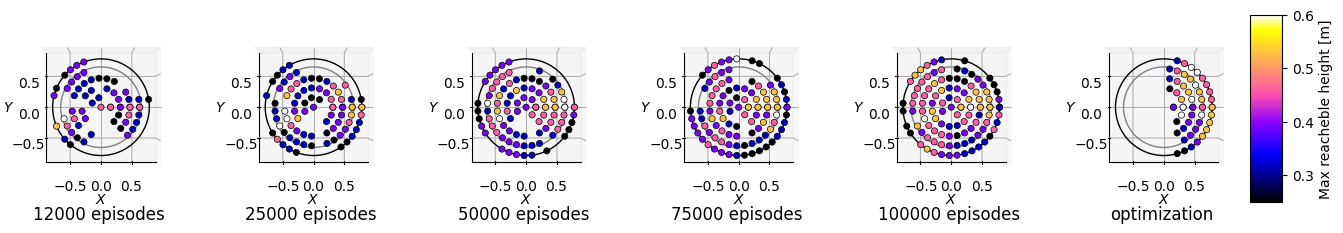

In [75]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs_256/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values.copy()
    
    perc_error*=100
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)  

    # generate surface
    xy_pair = []
    max_z = []

    for p in feasible_region:
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            max_z.append(p[2])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            if p[2] > max_z[idx]:
                # new z value
                max_z[idx] = p[2]

    surface = np.append(np.array(xy_pair),np.array(max_z).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d',computed_zorder=False)
    train_area = Circle( (0, 0),0.65, fill = False, color='gray')
    test_area = Circle( (0, 0),0.78, fill = False, color='black')
    ax.add_patch(train_area)
    ax.add_patch(test_area)
    art3d.pathpatch_2d_to_3d(train_area, z=0, zdir="z")
    art3d.pathpatch_2d_to_3d(test_area, z=0, zdir="z")
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-0.85, 0.85)
    ax.set_ylim(-0.85, 0.85)
    # ax.set_zlim(0, .7)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=-90,elev=90)
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-15)
    else:
        ax.set_title( 'optimization', y=.0, pad=-15)
    # surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.1, cmap=z_cmap, norm=z_norm)
    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], 0, alpha=1, edgecolors="black", linewidths=0.5, c=surface[:, 2], cmap=z_cmap, norm=z_norm)
    
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3 ,label='Max reacheble height [m]', cax=cbar_ax)

# fig.suptitle('Max heigt of filtered target positions [RPE $\leq$ 0.1]')
fig.savefig(os.path.join('plots', f'height_surface_plot.pdf'), dpi=500, bbox_inches='tight')
fig.show()

In [76]:
len(tests_error)

6

In [77]:
tests_error = np.array(tests_error)
# tests_error = tests_error

Text(0.5, 9.444444444444438, 'Relative percentual error [%]')

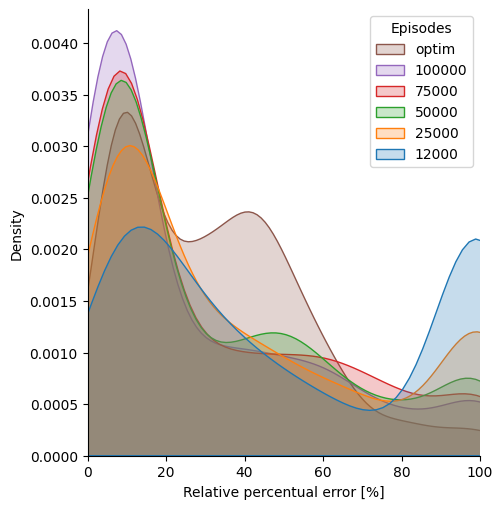

In [78]:
sns.displot([e for e in tests_error],kind='kde',fill=True,legend=False)
plt.legend(title="Episodes",labels=tests[::-1])
plt.xlim(0,100)
plt.savefig('err_dist.jpg',dpi=200)
plt.xlabel("Relative percentual error [%]")
# plt.savefig(os.path.join('plots', 'error_density.png'), dpi=500)

In [79]:
tests_error.shape

(6, 726)

In [80]:
tests_error_128 = []

In [81]:
for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs_128/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
        
        perc_error*=100
        tests_error_128.append(perc_error)

In [82]:
tests_error_128 = np.array(tests_error_128)

In [83]:
target_points

array([[-7.77470700e-01,  6.27639236e-02,  2.50000000e-01],
       [-7.77470700e-01,  6.27639236e-02,  3.20000000e-01],
       [-7.77470700e-01,  6.27639236e-02,  3.90000000e-01],
       ...,
       [ 7.80000000e-01,  9.55224503e-17,  4.60000000e-01],
       [ 7.80000000e-01,  9.55224503e-17,  5.30000000e-01],
       [ 7.80000000e-01,  9.55224503e-17,  6.00000000e-01]])

In [84]:
back_index = (target_points[:,0] <= 0) & (np.linalg.norm(target_points[:,:2],axis=-1) <= 0.63) & (target_points[:,2] <= 0.53)

In [85]:
front_index = (target_points[:,0] >= 0) & (np.linalg.norm(target_points[:,:2],axis=-1) <= 0.63) & (target_points[:,2] <= 0.53)

In [86]:
back = target_points[back_index]
front = target_points[front_index]


/tmp/ipykernel_991655/3038748473.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_991655/3038748473.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


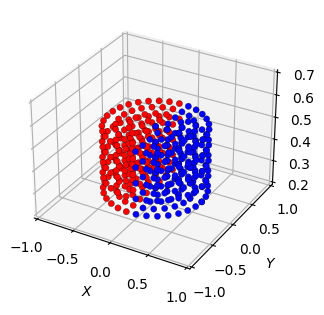

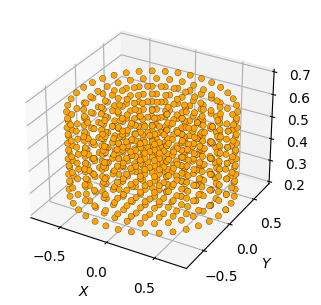

In [87]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(1, len(tests), i+1, projection='3d')
ax.margins(x=0,y=0,z=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0.2, .7)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
# ax.view_init(azim=-90,elev=90)
ax.scatter(back[:, 0], back[:, 1], back[:, 2], alpha=1, edgecolors="black", linewidths=0.2, color = 'red')
ax.scatter(front[:, 0], front[:, 1], front[:, 2], alpha=1, edgecolors="black", linewidths=0.2, color = 'blue')
fig.show()

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(1, len(tests), i+1, projection='3d')
ax.margins(x=0,y=0,z=0)
ax.set_xlim(-.79, .79)
ax.set_ylim(-.79, .79)
ax.set_zlim(0.2, .7)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
# ax.view_init(azim=-90,elev=10)
ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], alpha=1, edgecolors="black", linewidths=0.2, color = 'orange')
fig.show()

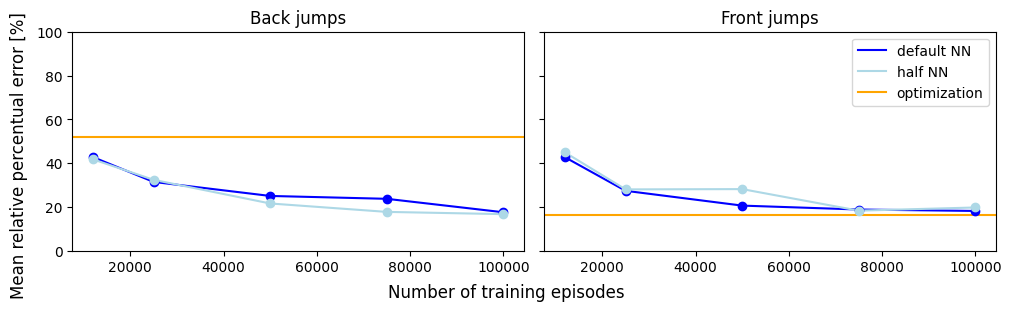

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True, figsize=(10,3))

# back jump
ax1.set_ylim(0,100)
ax1.plot(tests[:-1],np.mean(tests_error[:-1,back_index],axis=1), color='blue', label="default NN")
ax1.plot(tests[:-1],np.mean(tests_error_128[:,back_index],axis=1), color='lightblue', label="half NN")

ax1.scatter(tests[:-1],np.mean(tests_error[:-1,back_index],axis=1), color='blue', zorder=2.5)
ax1.scatter(tests[:-1],np.mean(tests_error_128[:,back_index],axis=1), color='lightblue', zorder=2.5)

ax1.axhline(np.mean(tests_error[-1,back_index]),color='orange',label='optimization')
ax1.set_title('Back jumps')

# front jump
ax2.set_ylim(0,100)
ax2.plot(tests[:-1],np.mean(tests_error[:-1,front_index],axis=1), color='blue', label="default NN")
ax2.plot(tests[:-1],np.mean(tests_error_128[:,front_index],axis=1), color='lightblue', label="half NN")

ax2.scatter(tests[:-1],np.mean(tests_error[:-1,front_index],axis=1), color='blue', zorder=2.5)
ax2.scatter(tests[:-1],np.mean(tests_error_128[:,front_index],axis=1), color='lightblue', zorder=2.5)

ax2.axhline(np.mean(tests_error[-1,front_index]),color='orange',label='optimization')
ax2.set_title('Front jumps')
ax2.legend()


fig.supxlabel('Number of training episodes')
fig.supylabel('Mean relative percentual error [%]')

plt.savefig(os.path.join('plots', 'jumps_avg_error.pdf'), dpi=500,  bbox_inches='tight')
plt.show()

In [89]:

# plt.plot(tests[:-1],np.mean(tests_error[:-1,:],axis=1), color='blue', label="default NN")
# plt.scatter(tests[:-1],np.mean(tests_error[:-1,:],axis=1), color='blue')

# plt.plot(tests[:-1],np.mean(tests_error_128,axis=1), color='lightblue', label="half NN")
# plt.scatter(tests[:-1],np.mean(tests_error_128,axis=1), color='lightblue')


# plt.axhline(np.mean(tests_error[-1,:]),color='orange',label='optimization')
# plt.xlabel('Number of episodes')
# plt.ylabel('Mean relative percentual error [%]')
# plt.legend()
# plt.savefig(os.path.join('plots', 'avg_error.png'), dpi=500,  bbox_inches='tight')
# plt.show()